# Genodesic Tutorial on the Schiebinger Dataset

This notebook demonstrates the end-to-end **Genodesic** pipeline for trajectory reconstruction. Our goal is to find a biologically meaningful path between two cell states in the Schiebinger dataset. We achieve this by computing a geodesic with respect to a data-density-aware Fermat metric, which ensures the path realistically follows the underlying data manifold.

The analysis is broken down into four key stages:

1.  **Data Preparation and Latent Space Generation:** We begin by downloading the dataset and preparing it for analysis. This involves selecting the most informative Highly Variable Genes (HVGs) from the raw counts. We then train an autoencoder to project this high-dimensional gene data into a lower-dimensional, more manageable latent space. This latent representation forms the foundation for all subsequent steps.

2.  **Score-Based Density Modeling:** We train a VP-SDE (Variance Preserving Stochastic Differential Equation) model on the latent space data. This model learns the score field ($\boldsymbol{s = \nabla_x \log p}$), which captures the gradient of the data's log-density. This score is crucial for guiding the pathfinding algorithm, ensuring the trajectory stays in high-density regions of the data manifold.

3.  **Geodesic Pathfinding and Refinement:** We select start and end cells from different developmental timepoints within the latent space. An initial path is proposed using a Dijkstra search on a k-nearest neighbors graph. This rough initialization is then iteratively refined into a smooth, optimized geodesic using our trained score model. This step ensures the final path is both short and conforms to the learned data geometry.

4.  **Analysis and Biological Validation:** Finally, we analyze and validate the computed trajectory. We compare the geometric and likelihood-based properties of the initial and refined paths. To assess biological relevance, we decode the refined latent path back into gene expression space and visualize the resulting gene cascade as a heatmap. This allows us to interpret the trajectory as a sequence of dynamic gene expression changes over developmental time.

## Global Notebook Configuration

This section contains all the key parameters for the entire pipeline. It's the main control panel for this notebook.

**Default Parameters & Overrides:**
The Genodesic package uses YAML files (`Config/models.yaml` and `Config/refinement.yaml`) to store default hyperparameters for training and path refinement. Below, we define Python dictionaries that override these defaults for specific experiments.

In [1]:
import os
import torch

# --- A. Global Toggles & Setup ---
ReextractHVGs = False
RetrainAutoencoder = False
RetrainDensity = False 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- B. Define Core Parameters ---
TRUNK = "both"
N_HVG = 2000
BOTTLENECK_DIM = 24
MODEL_TYPE = "vpsde"  # Options: "vpsde", "otcfm", "rqnsf"

# --- C. Dynamically Generate All File Paths ---
hvg_output_file = f"schiebinger_hvg_tensor_trunk-{TRUNK}_{N_HVG}hvg.pt"
hvg_tensor_path = os.path.join("Pipeline/HVGs", hvg_output_file)

ae_model_save_path = f"Models/Autoencoder/trunk-{TRUNK}_dim-{BOTTLENECK_DIM}_hvg-{N_HVG}.pt"
latent_save_path = f"LatentSpace/trunk-{TRUNK}_dim-{BOTTLENECK_DIM}_hvg-{N_HVG}_latent.pt"
density_model_save_path = f"Models/DensityModels/{MODEL_TYPE}_trunk-{TRUNK}_dim-{BOTTLENECK_DIM}.pt"

# --- D. Define All Overrides 
notebook_overrides = {
    "hvg_extraction": {
        "output_file": hvg_output_file,
        "trunk": TRUNK,
        "n_hvg": N_HVG,
        "min_counts": 2000,
        "max_counts": 50000,
        "min_cells": 50,
    },
    "autoencoder": {
        "model_save_path": ae_model_save_path,
        "latent_save_path": latent_save_path,
        "bottleneck_dim": BOTTLENECK_DIM,
        "num_epochs": 10,
        "learning_rate": 0.0005,
    },

    "density_model": {
        "model_type": MODEL_TYPE,
        "data_file": latent_save_path,
        "model_save_path": density_model_save_path,
        "dim": BOTTLENECK_DIM,
        "num_epochs": 75,
        "batch_size": 512,
    }
}

# 0: Downloading the Schiebinger Dataset

We first download and extract the Schiebinger Dataset. As this can be a bit tricky, we provide a shell script that automatically downloads the entire dataset and extracts it to Data/Schiebinger. If a dataset is already found at that path, the download is skipped.

In [2]:
%%bash
Pipeline/SchiebingerDownload.sh

--- Schiebinger Dataset Downloader ---
Directory Data/Schiebinger already exists and is not empty.
Continuing: will attempt to extract/unpack any archives found in this directory.
Skipping cleanup as no new download was performed.
---
Dataset is located in: Data/Schiebinger


# 1: Extracting HVGs of chosen Branch

We now combine all datasets and filter for the desired branch. Afterwards we run HVG extraction and save the new combined HVG count matrix to disk. Per default the extraction is skipped if the count matrix already exists. The boolean `ReextractHVGs` overwrites this check. 


In [3]:
from Genodesic.Utils import load_config
from Pipeline.firstSelectHVGs import run_hvg_extraction
import matplotlib.pyplot as plt

if os.path.exists(hvg_tensor_path) and not ReextractHVGs:
    print(f"File {hvg_output_file} already exists. Skipping.")
else:
    print("Starting HVG extraction...")
    hvg_config = load_config(
        default_config_path='Config/hvg_extraction.yaml',
        overrides=notebook_overrides
    )
    hvg_fig = run_hvg_extraction(
        config=hvg_config,
        data_dir="Data/Schiebinger",
        debug=True
    )
    if hvg_fig: plt.show()

File schiebinger_hvg_tensor_trunk-both_2000hvg.pt already exists. Skipping.


# 2: Training the Autoencoder

In [4]:
from Pipeline.secondTrainAutoencoder import run_autoencoder_training

if os.path.exists(ae_model_save_path) and not RetrainAutoencoder:
    print(f"Model already exists at {ae_model_save_path}. Skipping training.")
else:
    print("Starting autoencoder training...")
    ae_config = load_config(
        default_config_path='Config/autoencoder.yaml',
        overrides=notebook_overrides
    )
    run_autoencoder_training(
        hvg_tensor_file=hvg_tensor_path,
        config=ae_config,
        debug=False
    )

Model already exists at Models/Autoencoder/trunk-both_dim-24_hvg-2000.pt. Skipping training.


## 2.1: Visualizing the Latent Space

In [5]:
from Genodesic.Visualizers import UMAP3D

latent_data_bundle = torch.load(latent_save_path)
latent_reps = latent_data_bundle['latent_reps'].numpy()
timepoints = latent_data_bundle['timepoints'].numpy().flatten()

print(f"Loaded {latent_reps.shape[0]} latent vectors.")

UMAP3D(
    latent_reps=latent_reps,
    color_by_timepoints=timepoints,
    title=f"Latent Space UMAP (Trunk: {TRUNK})"
)

cuML found. Using GPU for UMAP acceleration.
Loaded 249047 latent vectors.
--- Starting 3D Visualization ---
Fitting UMAP model...
Creating k3d plot...
Coloring by continuous timepoints and adding a color bar.
--- Visualization Complete ---


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

# 3: Setting up Density Models

In [6]:
from Pipeline.train import run_training
from Genodesic.Utils import load_density_model_from_checkpoint

if os.path.exists(density_model_save_path) and not RetrainDensity:
    model = load_density_model_from_checkpoint(density_model_save_path, device=DEVICE)
else:
    print("Starting density model training...")
    density_config = load_config(
        default_config_path='Config/DensityModels.yaml',
        overrides=notebook_overrides.get("density_model", {})
    )
    model = run_training(config=density_config)

print(f"\nSuccessfully loaded model: {model.__class__.__name__}")


Loading model of type 'vpsde' from Models/DensityModels/vpsde_trunk-both_dim-24.pt...

Successfully loaded model: ScoreSDEModel


# 4: Trajetories

## 4.1 Initialization of Path

First we choose the start and end time and then sample two random cells from the subsamples that are to be connected

In [7]:
import numpy as np

start_time = 3
end_time = 15

# Find indices for each timepoint
start_idx = np.random.choice(np.where(timepoints == start_time)[0])
end_idx = np.random.choice(np.where(timepoints == end_time)[0])


We now initialize a path between the two sampled cells by performing a Dijkstra on the knn graph of the dataset:

In [8]:
from Genodesic.PathTools import find_dijkstra_path

init_path = find_dijkstra_path(start_idx, end_idx, latent_reps)
UMAP3D(
    paths=[init_path],
    latent_reps=latent_reps,
    color_by_timepoints=timepoints
)

Building k-NN graph (k=10) for Dijkstra...
Running lazy Dijkstra's from 31326 to 176455...
--- Starting 3D Visualization ---
Fitting UMAP model...
Creating k3d plot...
Coloring by continuous timepoints and adding a color bar.
Transforming and plotting 1 paths...
--- Visualization Complete ---


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## 4.2 Refinement

We now run the refinement loop. It takes the path initialization and runs the geodesic relaxation scheme and resampling. The behavior can be configured in the [refinement.yaml](Config/refinement.yaml).

In [9]:
from Genodesic.PathTools import run_refinement_loop

refined_path = run_refinement_loop(
    phi_initial=init_path,
    model=model
)


Relaxation: 100%|██████████| 50/50 [00:00<00:00, 3271.18it/s]


We can compare the two paths in a UMAP

In [10]:
from Genodesic.Visualizers import UMAP3D

UMAP3D(
    paths=[init_path, refined_path],
    latent_reps=latent_reps,
    color_by_timepoints=timepoints
)

--- Starting 3D Visualization ---
Fitting UMAP model...
Creating k3d plot...
Coloring by continuous timepoints and adding a color bar.
Transforming and plotting 2 paths...
--- Visualization Complete ---


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## 4.3 Analysing the trajectories

We now analyze both the euclidean length as well as the likelihood of the path

--- Calculating Path Statistics ---
Processing 'Initial Path'...
Processing 'Relaxed Path'...
Calculations complete.



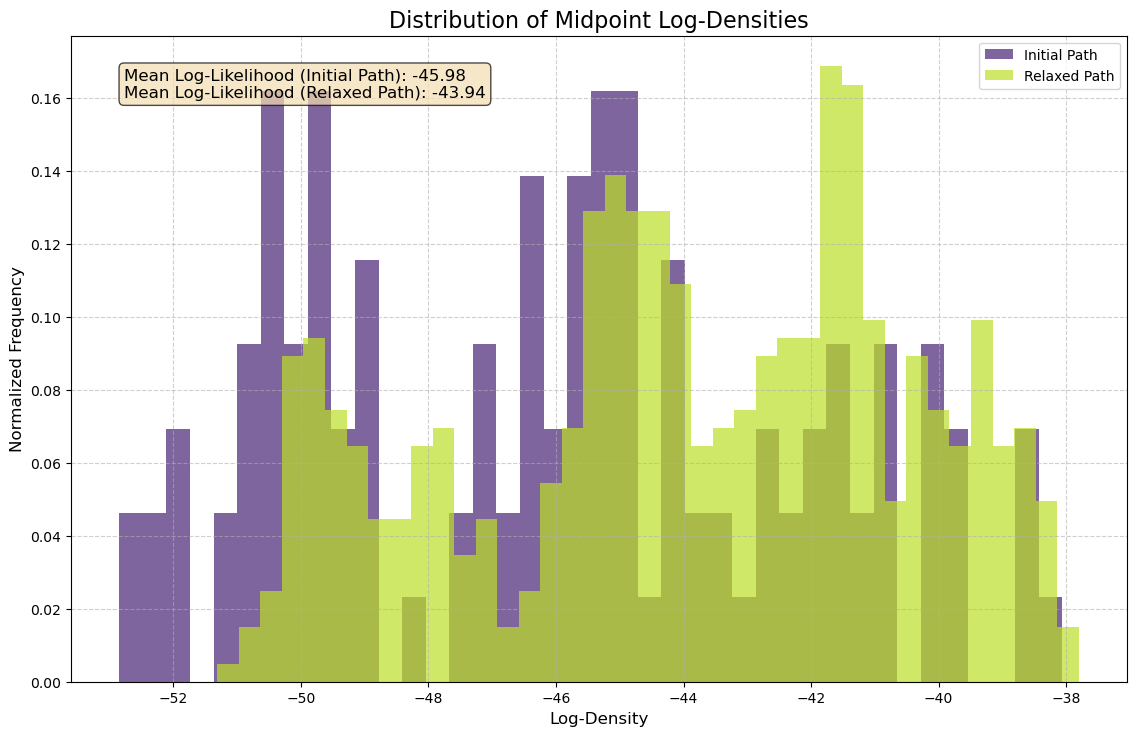

--- Path Statistics ---

Initial Path:
  Euclidean Length: Mean=3.478, Std=1.313, Min=1.768, Max=6.869, Total=135.629
  Log-Density:      Mean=-45.984, Std=3.808
  Fermat Length:    0.003 (beta=-0.25)

Relaxed Path:
  Euclidean Length: Mean=0.509, Std=0.006, Min=0.484, Max=0.514, Total=101.353
  Log-Density:      Mean=-43.940, Std=3.406
  Fermat Length:    0.002 (beta=-0.25)

--- Total Arc Length Comparison ---
Reference Path: 'Initial Path' (Total Length: 135.629)
  vs. 'Relaxed Path': 101.353 (Change: -25.27%)


In [11]:
from Genodesic.PathTools import calculate_path_statistics

paths_to_analyze = {
    'Initial Path': torch.from_numpy(init_path),
    'Relaxed Path': refined_path
}

path_statistics = calculate_path_statistics(
    paths_dict=paths_to_analyze,
    model=model,
    beta_param=-1/4,
    integration_steps=2
)

from Genodesic.PathTools import report_path_statistics
report_path_statistics(
    stats_dict=path_statistics,
    reference_path_name='Initial Path',
    beta_param=-1/4,  
)

We can see, that the likelihood of the path is somewhat reduced whist significantly reducing the euclidean length of the path. This demonstrates the principle that the geodesic finds shorter paths in the dataspace.

## 4.4 Genetic cascade

We now take the relaxed path and decode it again into count space. In count space we now analyze for the most variable genes along the path and plot them ordered by their mode. This visualizes the most relevant genetic cascade along the trajectory.

--- Loading AutoEncoder and Gene Metadata ---
Successfully loaded AutoEncoder on cuda with 2000 genes.

--- Decoding Latent Trajectory ---
Decoded path to an expression curve of shape (200, 2000)

--- Identifying Dynamic Genes ---

--- Plotting Heatmap ---


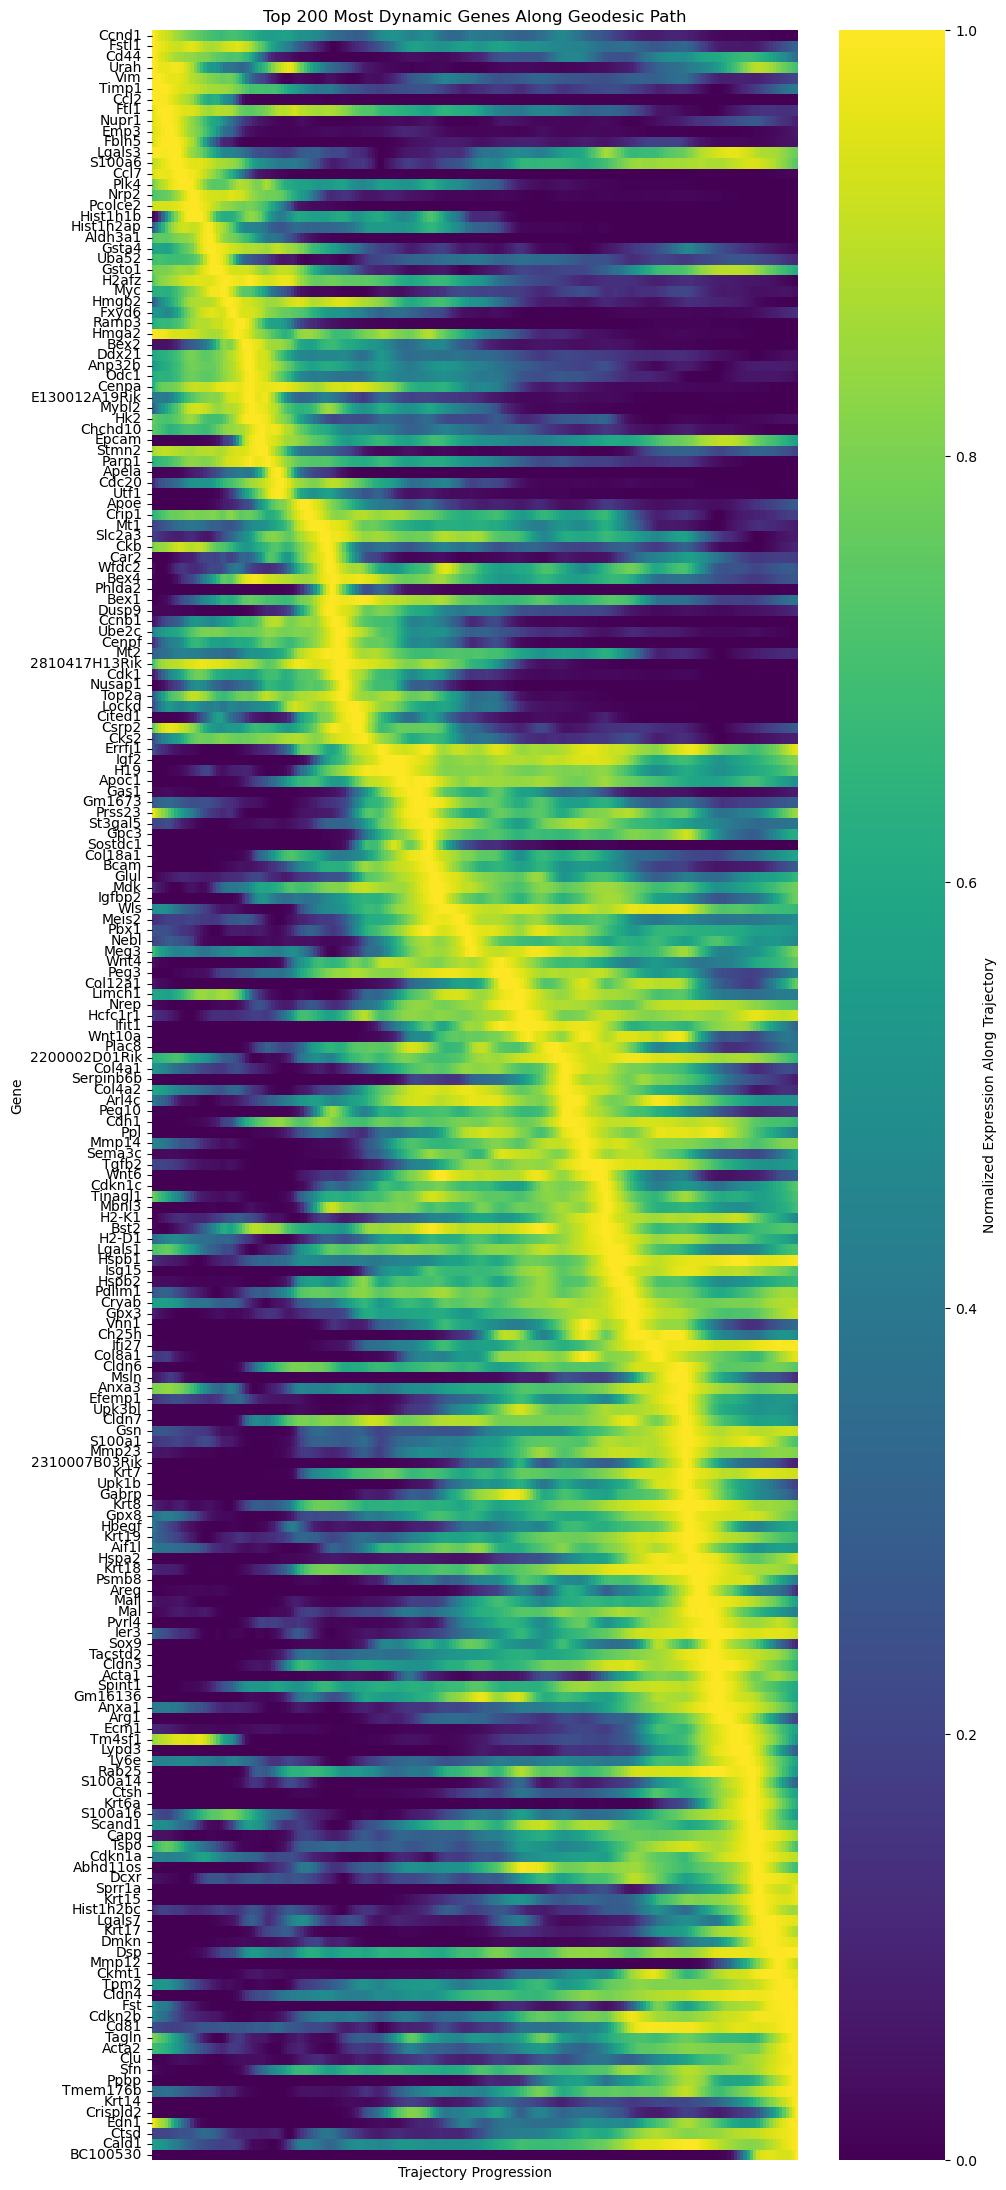

In [12]:
import matplotlib.pyplot as plt
from Genodesic.Visualizers import (
    load_autoencoder_and_metadata,
    decode_latent_trajectory,
    find_dynamic_genes,
    plot_dynamic_genes_heatmap
)

# --- 1. Load Model and Gene Metadata ---
try:
    autoencoder_model, hvg_gene_names = load_autoencoder_and_metadata(
        ae_checkpoint_path=ae_model_save_path,
        hvg_tensor_path=hvg_tensor_path,
        device=DEVICE
    )
except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure previous steps have run successfully. Details: {e}")
    raise

# --- 2. Decode Latent Path to Gene Expression ---
print("\n--- Decoding Latent Trajectory ---")
expression_curve = decode_latent_trajectory(
    autoencoder_model=autoencoder_model,
    latent_path=refined_path, # Assuming phi_relaxed is available from a previous cell
    device=DEVICE
)
print(f"Decoded path to an expression curve of shape {expression_curve.shape}")

# --- 3. Find and Order Dynamic Genes ---
print("\n--- Identifying Dynamic Genes ---")
ordered_expression_data, ordered_gene_names = find_dynamic_genes(
    expression_curve=expression_curve,
    gene_names=hvg_gene_names,
    num_genes=200 
)

# --- 4. Plot Heatmap ---
print("\n--- Plotting Heatmap ---")
plot_dynamic_genes_heatmap(
    expression_data=ordered_expression_data,
    gene_names=ordered_gene_names,
    figsize=(10, 22)
)

## 4.5 Schiebinger Wallclock-Time comparison

As the Schiebinger dataset provides a wallclock time for each true datapoint we can compare our path against the wallclock time progression. The path trajectories however are not from the dataset and thus do not contain that information. Thus we take the wallclock time of the neighbours as a standin. For each path node we compute the average wallclock time of the 10 nearest neighbours and plot it's progression against the path progression including it's variance. The Genodesic package contains all relevant functions

Computing average pseudotime along path (k=10)...
Plotting multiple pseudotime progressions on a normalized axis...


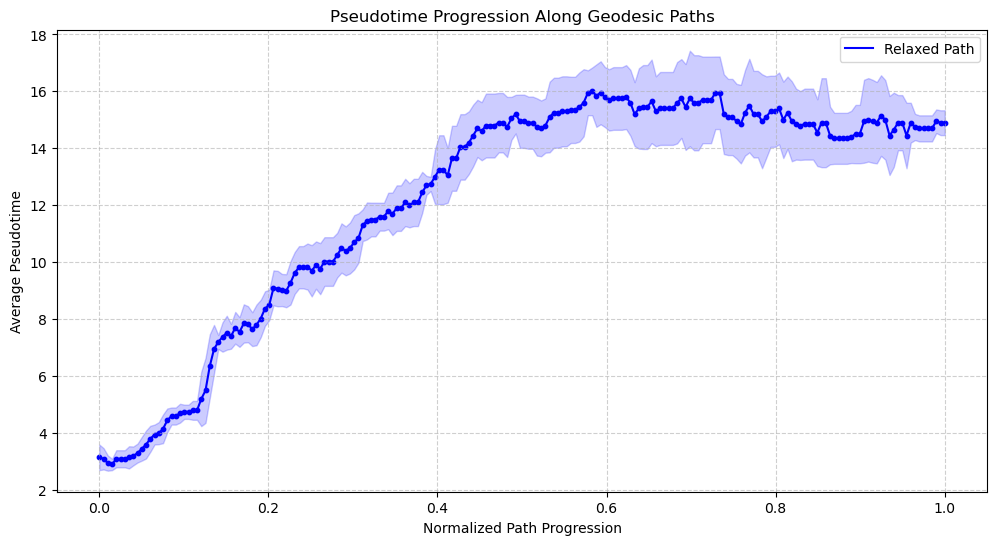

In [15]:
from Genodesic.PathTools.Wallclock import compute_path_pseudotime
from Genodesic.PathTools.Diagnostics import plot_pseudotime_progressions



avg_relaxed, std_relaxed = compute_path_pseudotime(
    refined_path, latent_reps, timepoints, k=10
)


all_results = [
    (avg_relaxed, std_relaxed, 'Relaxed Path'),
]


plot_pseudotime_progressions(
    all_results, 
    colors=['blue', 'green', 'red']
)
   
